In [1]:
# mount gdrive
#
# from google.colab import drive
# drive.mount('/gdrive')

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import random
import os
import tensorflow as tf
from PIL import Image
import logging
from tqdm import tqdm
import cv2

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
print(tf.__version__)

2.11.0


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
#Extracting the zipped archive into the folder in which I am 

# !unzip -q ../gdrive/MyDrive/ATDL/resized_train2.zip

In [57]:
concepts_path = 'data/caption_prediction_train.csv'

df_captions = pd.read_csv(concepts_path, sep=';', names=['Id', 'Caption'])

In [58]:
df_captions.head()

,Id,Caption
0,ImageCLEFmedCaption_2022_train_000001,pericardial tamponade with clear distinction o...
1,ImageCLEFmedCaption_2022_train_000002,angiography of the aortic arch show delay visu...
2,ImageCLEFmedCaption_2022_train_000003,balloonocclude retrograde transvenous oblitera...
3,ImageCLEFmedCaption_2022_train_000004,film after glue embolization show no filling i...
4,ImageCLEFmedCaption_2022_train_000005,peripheral in posteroanterior projection angio...


In [59]:
df_captions['Id'] = df_captions['Id'].str[-6:]
df_captions.head()

,Id,Caption
0,000001,pericardial tamponade with clear distinction o...
1,000002,angiography of the aortic arch show delay visu...
2,000003,balloonocclude retrograde transvenous oblitera...
3,000004,film after glue embolization show no filling i...
4,000005,peripheral in posteroanterior projection angio...


In [60]:
captions = df_captions.to_numpy()
np.save('data/captions.npy', captions)

In [61]:
df_captions.head()

,Id,Caption
0,000001,pericardial tamponade with clear distinction o...
1,000002,angiography of the aortic arch show delay visu...
2,000003,balloonocclude retrograde transvenous oblitera...
3,000004,film after glue embolization show no filling i...
4,000005,peripheral in posteroanterior projection angio...


In [0]:

def convert_to_numpy(in_dir, out_dir, filename_transform=None):
    ids = []
    for filename in tqdm(os.listdir(in_dir)):
        if (filename.endswith(".jpg")):
            image = cv2.imread(filename=os.path.join(in_dir, filename), flags=cv2.IMREAD_COLOR)
            if image.shape != (128, 128, 3):
                print('Error')
            if filename_transform:
                filename = filename_transform(filename)
            np.save(os.path.join(out_dir, filename), np.array(image))
            ids.append(filename)
    return ids


transform = lambda x: x[:-6]

train_ids = []
val_ids = []
test_ids = []
if os.path.exists('data/resized_train_numpy/train') and len(os.listdir('data/resized_train_numpy/train')) == 68525:
    in_dir = 'data/resized_train_numpy/train'
    for filename in tqdm(os.listdir(in_dir)):
        if filename.endswith(".npy"):
            train_ids.append(filename[:-4])
else:
    train_ids = convert_to_numpy('data/resized_train', 'data/resized_train_numpy/train', transform)

if os.path.exists('data/resized_train_numpy/validation') and len(
        os.listdir('data/resized_train_numpy/validation')) == 8064:
    in_dir = 'data/resized_train_numpy/validation'
    for filename in tqdm(os.listdir(in_dir)):
        if filename.endswith(".npy"):
            val_ids.append(filename[:-4])
else:
    val_ids = convert_to_numpy('data/validation', 'data/resized_train_numpy/validation', transform)

if os.path.exists('data/resized_train_numpy/test') and len(os.listdir('data/resized_train_numpy/test')) == 7532:
    in_dir = 'data/resized_train_numpy/test'
    for filename in tqdm(os.listdir(in_dir)):
        if filename.endswith(".npy"):
            test_ids.append(filename[:-4])
else:
    test_ids = convert_to_numpy('data/test', 'data/resized_train_numpy/test', transform)


In [68]:

captions_train = captions[:len(train_ids)]
captions_val = captions[len(train_ids):len(train_ids) + len(val_ids)]
captions_test = captions[len(train_ids) + len(val_ids):]

for i in range(len(captions_train)):
    assert captions_train[i][0] == train_ids[i]

for i in range(len(captions_val)):
    assert captions_val[i][0] == val_ids[i]

for i in range(len(captions_test)):
    assert captions_test[i][0] == test_ids[i]

captions_train = np.array(captions_train[:, 1])
captions_val = np.array(captions_val[:, 1])
captions_test = np.array(captions_test[:, 1])


#Load np dataset

In [69]:
class ClipDataLoader(tfk.utils.Sequence):
    def __init__(self, list_IDs, captions, batch_size=32, dim=(32, 32, 32),
                 shuffle=True):
        """Initialization"""
        self.indexes = None
        self.captions = captions
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.zeros(self.batch_size, dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

        return X, y

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        captions = self.captions[indexes]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return (X, captions), y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [70]:
train_generator = ClipDataLoader(train_ids, captions, batch_size=32)

#Importing pre-trained model

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088

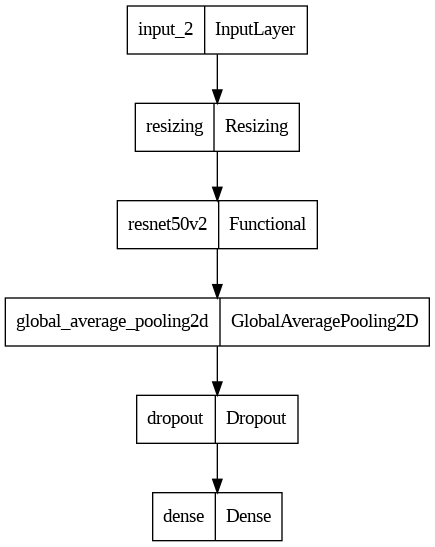

In [ ]:
from tensorflow.keras import regularizers

base_model = tfk.applications.resnet_v2.ResNet50V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = tfk.Input(shape=(128, 128, 3))
x = tf.keras.layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=True, )(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.5, seed=seed)(x)
output_layer = tfkl.Dense(
    512,
    activation='leaky_relu')(x)

tl_model = tfk.Model(inputs, output_layer)

# tl_model.compile(optimizer=tfk.optimizers.Adam(0.0001),
#               loss=tfk.losses.CategoricalCrossentropy(),
#               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# tl_model.summary()

# tfk.utils.plot_model(base_model)

tl_model.summary()
tfk.utils.plot_model(tl_model)


#Transformer

In [ ]:
!pip install -q opencv-python
!pip install -q tf-models-official
#!pip install -q -U "tensorflow-text==2.9.*"

In [ ]:
!pip install --upgrade tensorflow-hub
!pip install --upgrade tensorflow.text
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
#import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_models as tfm

nlp = tfm.nlp

tfds.disable_progress_bar()

In [ ]:
print(tf.__version__)

2.9.2


# Tokenization

In [ ]:
# The following directory contains the BERT model's configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    lower_case=True)

In [ ]:
tokens = tokenizer(tf.constant(["Hello TensorFlow!"]))
tokens

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>

In [ ]:
max_seq_length = 512

packer = tfm.nlp.layers.BertPackInputs(
    seq_length=max_seq_length,
    special_tokens_dict=tokenizer.get_special_tokens_dict())

In [ ]:
sentences1 = ["hello tensorflow"]
tok1 = tokenizer(sentences1)
tok1

<tf.RaggedTensor [[[7592], [23435, 12314]]]>

In [ ]:
packed = packer(tok1)

for key, tensor in packed.items():
    print(f"{key:15s}: {tensor[:, :]}")

input_word_ids : [[  101  7592 23435 12314   102     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0  

In [ ]:
class BertInputProcessor(tf.keras.layers.Layer):
    def __init__(self, tokenizer, packer):
        super().__init__()
        self.tokenizer = tokenizer
        self.packer = packer

    def call(self, inputs):
        tok1 = self.tokenizer(inputs['sentence1'])

        packed = self.packer(tok1)
        return packed

In [ ]:
bert_inputs_processor = BertInputProcessor(tokenizer, packer)
packer(tokenizer([captions[0]]))

{'input_word_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
 array([[  101,  2566,  5555, 25070, 17214, 26029,  9648,  2007,  3154,
          7835,  1997,  8680,  4232,  4818,  3675,  1998,  2566,  5555,
         17080,  2819,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     

In [ ]:
import tqdm as tqdm

In [ ]:
captions_train = np.array(list(map(lambda x: packer(tokenizer([x])), captions)))

KeyboardInterrupt: ignored

In [ ]:
cfg = {
    "vocab_size": 512,
    "hidden_size": 512,
    "num_layers": 6,
    "num_attention_heads": 8,
    "intermediate_size": 512,
    "activation": tfm.utils.activations.gelu,
    "dropout_rate": 0.1,
    "attention_dropout_rate": 0.1,
    "max_sequence_length": 512,
    "type_vocab_size": 2,
    "initializer": tf.keras.initializers.TruncatedNormal(stddev=0.02),
    "embedding_width": 512
}
bert_encoder = nlp.networks.BertEncoder(**cfg)


In [ ]:
print(bert_encoder)

In [ ]:
print(bert_encoder.summary())

Model: "bert_encoder_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 word_embeddings (OnDeviceEmbed  (None, None, 512)   262144      ['input_word_ids[0][0]']         
 ding)                                                                                            
                                                                                                  
 input_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 position_embedding (PositionEm  (None, None, 512)   262144      ['word_embeddings[0]

In [ ]:
print(bert_encoder.get_layer(name="pooler_transform").output.shape)
print(output_layer.shape)
bert_output = tfkl.Reshape((1, 512), input_shape=(None, 512))(bert_encoder.get_layer(name="pooler_transform").output)
resnet_output = tfkl.Reshape((512, 1), input_shape=(None, 512))(output_layer)
output = tfkl.Dot(axes=(1, 2))([bert_output, resnet_output])

(None, 512)
(None, 512)


In [ ]:
output.shape

TensorShape([None, 512, 512])

In [ ]:
def myLoss(y_true, y_pred):
    labels = np.arange(y_pred.shape[0])
    loss_i = tfk.losses.CategoricalCrossentropy(y_pred, labels, axis=0)
    loss_t = tfk.losses.CategoricalCrossentropy(y_pred, labels, axis=1)
    return (loss_i + loss_t) / 2


In [ ]:
finalModel = tfk.Model([tl_model.input, bert_encoder.input], output)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 word_embeddings (OnDeviceEmbed  (None, None, 512)   262144      ['input_word_ids[0][0]']         
 ding)                                                                                            
                                                                                                  
 input_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 position_embedding (PositionEm  (None, None, 512)   262144      ['word_embeddings[0][0]']  

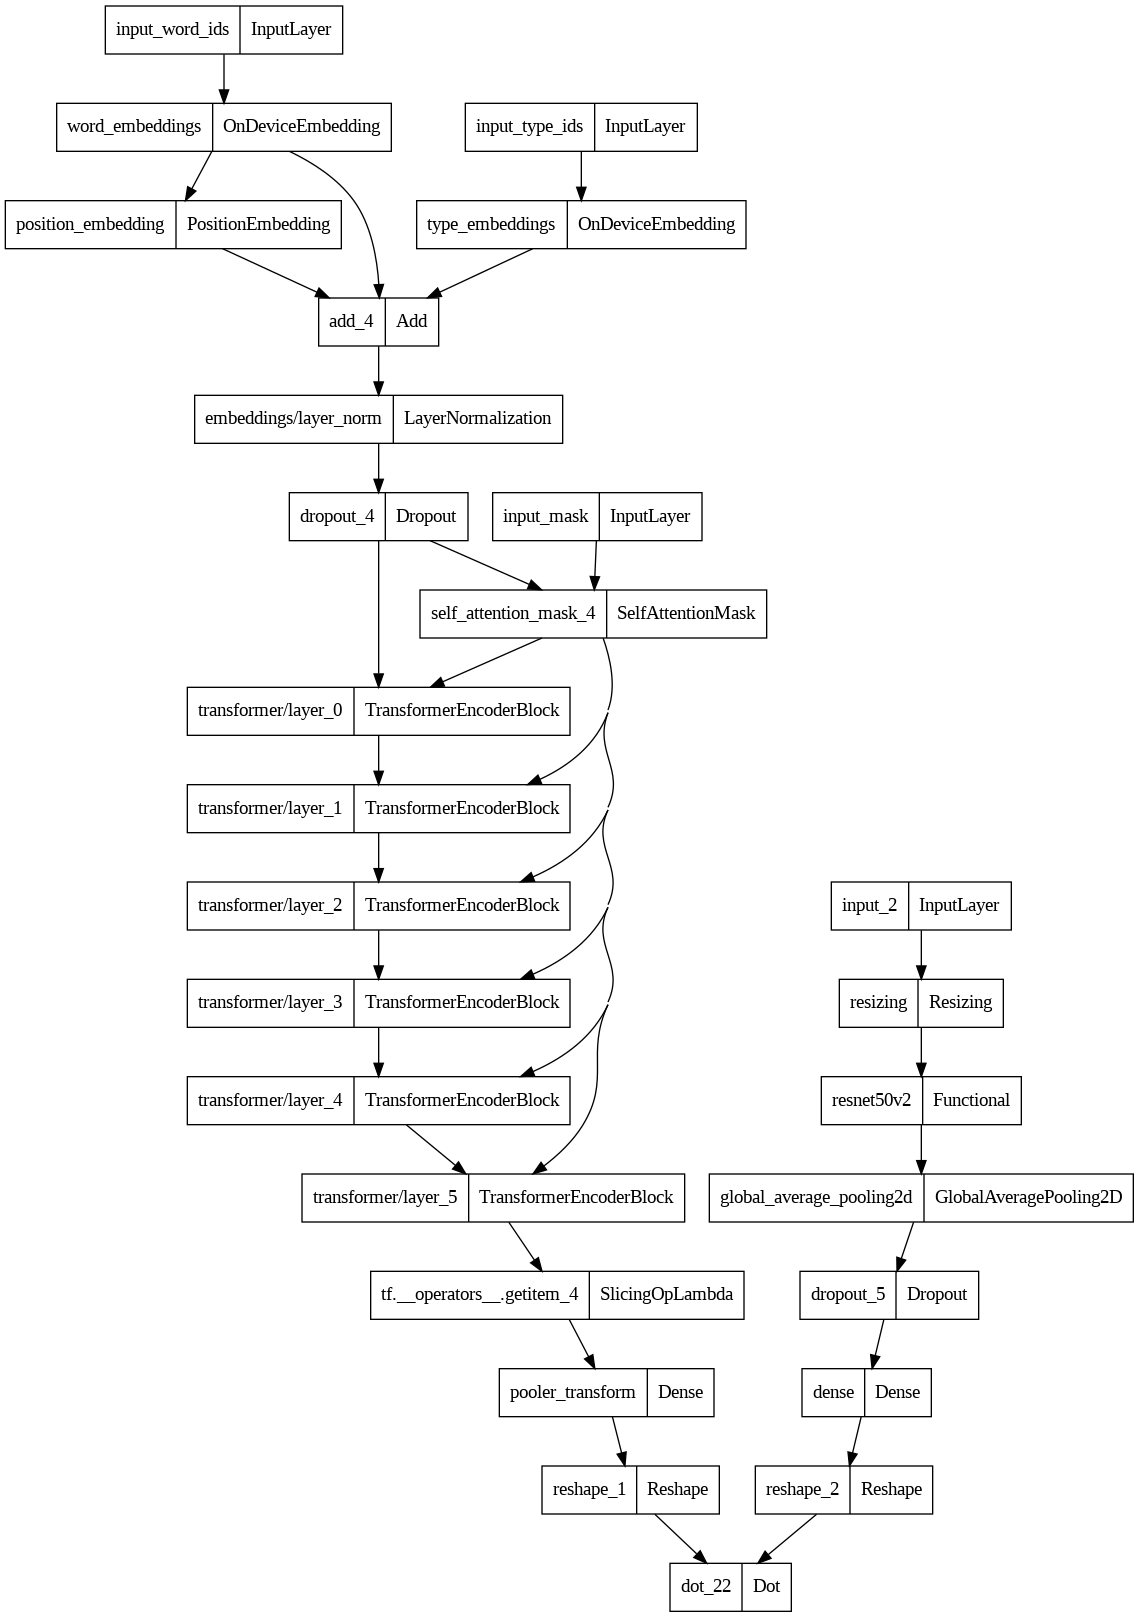

In [ ]:
finalModel.summary()
tfk.utils.plot_model(finalModel)

In [ ]:
finalModel.compile(optimizer=tfk.optimizers.Adam(), loss=myLoss)

In [ ]:
from tensorflow.python.ops.batch_ops import batch

tl_history = finalModel.fit(
    x=[x_data, captions],
    epochs=200,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/200


ValueError: ignored

#Test with AI

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.9 MB/s eta 0:00:00


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda
#from transformers import BertModel

In [8]:
# Embedding size for each token
embed_dim = 512
# Dimention of the latent space
latent_dim = 1024
# Number of attention heads
num_heads = 4
sequence_length = 512
vocab_size = 20000

In [9]:
def project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = tfkl.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = tfkl.Dense(projection_dims)(x)
        x = tfkl.Dropout(dropout_rate)(x)
        x = tfkl.Add()([projected_embeddings, x])
        projected_embeddings = tfkl.LayerNormalization()(x)
    return projected_embeddings

In [31]:
def build_resnet(size_embedding):
    # Load the ResNet50 model with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add a GlobalAveragePooling2D layer
    inputs = tfkl.Input(shape=(224, 224, 3), name="image_input")
    embeddings = base_model(inputs)
    embeddings = tfkl.GlobalAveragePooling2D()(embeddings)
    output = tfkl.Dense(size_embedding, activation='relu')(embeddings)

    # Build the ResNet50 model
    resnet = Model(inputs=inputs, outputs=output)
    resnet.summary()

    return resnet

In [ ]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

In [11]:
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"),
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)

    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [13]:
!pip install -q --upgrade keras-nlp tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.5/337.5 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 103.0 MB/s eta 0:00:00


In [19]:
import keras_nlp as nlp


def build_encoder():
    encoder_inputs = tfk.Input(shape=(512), dtype="int64", name="encoder_inputs")
    # Adding token and position embedding layer
    x = nlp.layers.TokenAndPositionEmbedding(vocab_size, sequence_length, embed_dim)(encoder_inputs)
    # Adding transformer encoder block
    encoder_outputs = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)

    # compute the mean of the non-masked embeddings
    pooled_output = tf.reduce_mean(encoder_outputs, axis=1)
    print(pooled_output.shape)

    #output = project_embeddings(pooled_output, 1, embed_dim, 0.1)

    # Defining the encoder model
    encoder = tfk.Model(encoder_inputs, pooled_output)
    # Print the summary of the encoder model
    encoder.summary()
    # Visualize the encoder model
    tfk.utils.plot_model(encoder)

    return encoder

In [15]:
def build_clip(resnet, transformer):
    # Create the input layer
    input_layer_transformer = Input(shape=(None,), dtype="int64", name="encoder_inputs")
    input_layer_resnet = Input(shape=(128, 128, 3))

    # Pass the input through the ResNet50 model
    input_layer_resized = tfkl.Resizing(224, 224)(input_layer_resnet)
    image_features = resnet(input_layer_resized)

    # Pass the input through the Transformer model
    text_features = transformer(input_layer_transformer)

    print(text_features.shape)
    print(image_features.shape)

    joint_features = tf.concat([image_features, text_features], axis=1)

    clip = Model(inputs=[input_layer_resnet, input_layer_transformer], outputs=joint_features)

    return clip

In [32]:
# Build the ResNet50 and Transformer models
resnet = build_resnet(512)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 512)               1049088   
                                                                 
Total params: 24,636,800
Trainable params: 1,049,088
Non-trainable params: 23,587,712
_________________________________________________________________


In [33]:
#Build encoder
encoder = build_encoder()

(None, 512)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 512)]            0         
                                                                 
 token_and_position_embeddin  (None, 512, 512)         10502144  
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_block_2  (None, 512, 512)         5253120   
  (TransformerEncoderBlock)                                      
                                                                 
 tf.math.reduce_mean_2 (TFOp  (None, 512)              0         
 Lambda)                                                         
                                                                 
Total params: 15,755,264
Trainable params: 15,7

In [34]:
clip = build_clip(resnet, encoder)

(None, 512)
(None, 512)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_3 (Resizing)          (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 model_5 (Functional)           (None, 512)          24636800    ['resizing_3[0][0]']       

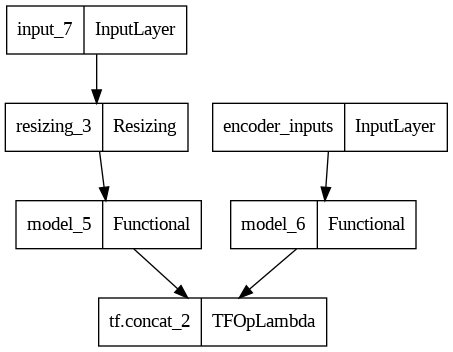

In [35]:
clip.summary()
tfk.utils.plot_model(clip)

In [26]:
#Preprocessing of the data

vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)

vectorization.adapt(captions)
captions = vectorization(captions)

In [ ]:
print(captions.shape)

(100, 512)


In [ ]:
batch_size = 32

In [ ]:
def make_dataset(data):
    # Create a dataset from the texts
    data = list(data)
    dataset = tf.data.Dataset.from_tensor_slices(data)
    # Batch the data
    dataset = dataset.batch(batch_size)
    # Shuffle the data, prefetch the next batch and cache the data 
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(captions)
train_image = make_dataset(x_data)

In [27]:
arr = np.zeros(shape=(100, 512), dtype="int64")
print(captions.shape)
for i in range(captions.shape[0]):
    a = np.asarray(list(captions[i][0:512]))
    diff = 512 - a.size
    b = np.zeros(diff, dtype="int64")
    final = np.concatenate((a, b))
    arr[i] = final

len(captions)

(100, 512)


100

In [ ]:
del (captions)

In [28]:
#Loss function not working
from tensorflow.keras.losses import cosine_similarity


def clip_loss_test(y_true, y_pred, temperature=0.1):
    # Split the predicted embeddings into image and text parts
    img_embed, text_embed = tf.split(y_pred, num_or_size_splits=2, axis=1)

    print("img", img_embed.shape)
    print("text", text_embed.shape)

    # Normalize the embeddings to unit length
    img_norm = tf.math.l2_normalize(img_embed, axis=1)
    text_norm = tf.math.l2_normalize(text_embed, axis=1)

    # Compute the cosine similarity between all pairs of image and text embeddings
    similarity_matrix = tf.matmul(img_norm, text_norm, transpose_b=True)
    print("similarity", similarity_matrix.shape)

    # Compute the diagonal elements of the similarity matrix, which correspond to
    # the cosine similarities between each image-text pair
    diagonal = tf.linalg.diag_part(similarity_matrix)
    print("Diagonal", diagonal.shape)

    # Compute the contrastive loss between the positive pairs (diagonal elements)
    # and the negative pairs (off-diagonal elements)
    positive_loss = tf.math.log(diagonal / (diagonal + 0.1))
    negative_loss = tf.math.log((1.0 - diagonal) / (0.9 * similarity_matrix + 1e-8))
    neg_loss = tf.reduce_mean(negative_loss)
    pos_loss = tf.reduce_mean(positive_loss)
    print("positive", pos_loss.shape)
    print("negative", neg_loss.shape)

    loss = positive_loss

    return loss

In [ ]:
#Loss function working
from tensorflow.keras.losses import cosine_similarity


def clip_loss(y_true, y_pred, temperature=0.1):
    # Split the predicted embeddings into image and text parts
    img_embed, text_embed = tf.split(y_pred, num_or_size_splits=2, axis=1)
    print(img_embed.shape)
    print(text_embed.shape)

    # Normalize the embeddings to unit length
    img_norm = tf.math.l2_normalize(img_embed, axis=1)
    text_norm = tf.math.l2_normalize(text_embed, axis=1)

    # Compute the cosine similarity between all pairs of image and text embeddings
    similarity_matrix = tf.matmul(img_norm, text_norm, transpose_b=True)

    # Compute the diagonal elements of the similarity matrix, which correspond to
    # the cosine similarities between each image-text pair
    diagonal = tf.linalg.diag_part(similarity_matrix)

    # Compute the contrastive loss between the positive pairs (diagonal elements)
    # and the negative pairs (off-diagonal elements)
    positive_loss = tf.math.log(diagonal / (diagonal + 0.1))
    negative_loss = tf.math.log((1.0 - diagonal) / (0.9 * similarity_matrix + 1e-8))

    loss = positive_loss

    return loss

In [29]:
learning_rate = 1e-4
optimizer = tfk.optimizers.Adam(learning_rate)
metrics = ["accuracy"]



In [ ]:
x_data.shape

(100, 128, 128, 3)

In [36]:
clip.compile(optimizer=optimizer, loss=clip_loss_test, metrics=metrics)

EPOCHS = 5

y_data = np.zeros((len(x_data), 512))
print(y_data.shape)

history = clip.fit(
    x=[x_data, arr],
    y=y_data,
    epochs=EPOCHS,
    batch_size=64
)

(100, 512)
Epoch 1/5
img (None, 512)
text (None, 512)
similarity (None, None)
Diagonal (None,)
positive ()
negative ()
img (None, 512)
text (None, 512)
similarity (None, None)
Diagonal (None,)
positive ()
negative ()
2/2 [==============================] - 17s 1s/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 1s 446ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 1s 455ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 1s 458ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 1s 454ms/step - loss: nan - accuracy: 0.0000e+00


#Test Ai 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Flatten
from tensorflow.keras.models import Model
from transformers import TFAutoModel, AutoTokenizer

# Load the pre-trained ResNet50V2 image encoder and freeze its weights
resnet = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
resnet.trainable = False

# Define the text encoder using a Transformer model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text_input = Input(shape=(None,), dtype=tf.int32)
text_encoder = TFAutoModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
text_features = text_encoder(text_input)[0]
text_features = Dense(512, activation="gelu")(text_features)

# Define the joint representation model
image_input = Input(shape=(128, 128, 3))
image_features = tfkl.Resizing(256, 256)(image_input)
image_features = resnet(image_input)
image_features = Flatten()(image_features)
image_features = Dense(512, activation="relu")(image_features)
print(image_features.shape)

image_features = tf.tile(tf.expand_dims(image_features, axis=1), [1, tf.shape(text_features)[1], 1])
joint_features = tf.concat([image_features, text_features], axis=1)
joint_model = Model(inputs=[image_input, text_input], outputs=joint_features)

# Define the contrastive learning objective
temperature = 0.1


@tf.function
def train_step(image_batch, text_batch):
    with tf.GradientTape() as tape:
        joint_representations = joint_model([image_batch, text_batch], training=True)
        logits_per_image, logits_per_text = clip.compute_logits(joint_representations, joint_representations)
        logits = tf.concat([logits_per_image, logits_per_text], axis=0)
        labels = tf.range(logits.shape[0])
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits / temperature))
    gradients = tape.gradient(loss, joint_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, joint_model.trainable_variables))
    return loss


optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)


(None, 512)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 resnet50v2 (Functional)        (None, None, None,   23564800    ['input_9[0][0]']                
                                2048)                                                             
                                                                                            

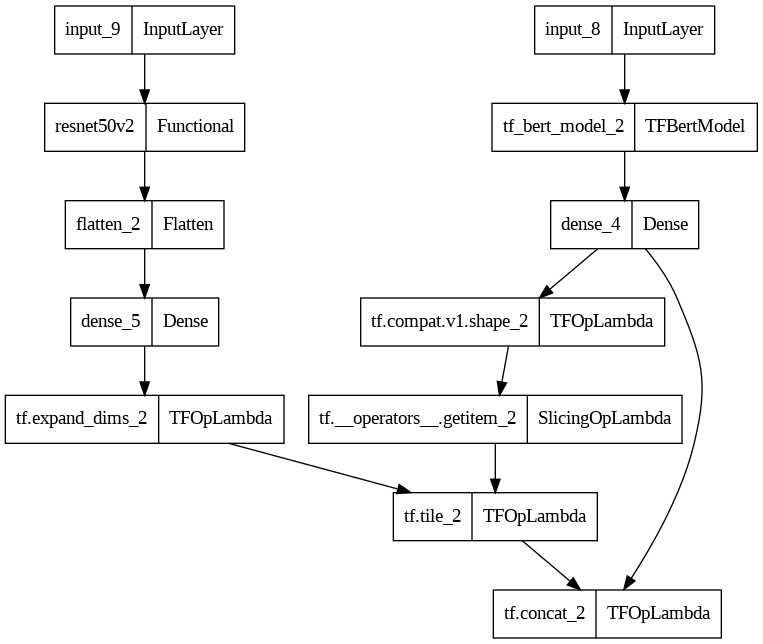

In [ ]:
joint_model.summary()
# Visualize the encoder model
tfk.utils.plot_model(joint_model)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_data, captions))
dataset = dataset.batch(64)

In [ ]:
num_epochs = 20

# Train the model on your data
for epoch in range(num_epochs):
    for batch in dataset:
        image_batch, text_batch = batch
        loss = train_step(image_batch, text_batch)
        # log loss, accuracy, etc.

ValueError: ignored